<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter11_UdonAI_VGG16_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11: UdonAI VGG16 Fine Tuning
画像分類のための深層学習モデルとしては高い精度が出る有名なモデルが多数知られており，ImageNetなどの大規模なデータセットを用いて学習させた学習済みモデルがインターネット上から入手することができます。実際の画像分類タスクではこの学習済みモデルを更に独自のデータセットを用いて再学習（ファインチューニング）を行い利用する場合が多くあります。ここではVGG16と呼ばれるモデルをファインチューニングしてみましょう。


## 準備

### パッケージのインポート

In [1]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=3,  suppress=True)
import seaborn as sns
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.5.0


### うどん店名のリストを作成

In [2]:
udonya_list = ["nagata-in-kanoka", "udon-bakaichidai", "yamagoe", "gamou", "hinode-seimenjo",
                      "ippuku", "moriya", "yoshiya", "sakaeda", "yamadaya"]

udonya_list

['nagata-in-kanoka',
 'udon-bakaichidai',
 'yamagoe',
 'gamou',
 'hinode-seimenjo',
 'ippuku',
 'moriya',
 'yoshiya',
 'sakaeda',
 'yamadaya']

## データの準備

### Googleドライブのマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブ内の`DL_Lecture_202107`ディレクトリを作業ディレクトリ`working_dir`として設定します。

In [4]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

### データの読み込み
Chapter07で作成したデータセット`udon10_dataset.npz`を読み込みます。

In [5]:
dataset_name = "udon10_dataset.npz"
dataset_path = os.path.join(working_dir, dataset_name)

data = np.load(dataset_path)

trainX = data["trainX"].astype("float32")
trainY = data["trainY"]
validX = data["validX"].astype("float32")
validY = data["validY"]
testX = data["testX"].astype("float32")

### 読み込んだデータのshapeを確認

In [6]:
print("Data Shape")
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("validX:", validX.shape)
print("validY:", validY.shape)
print("testX:", testX.shape)

Data Shape
trainX: (10000, 128, 128, 3)
trainY: (10000,)
validX: (500, 128, 128, 3)
validY: (500,)
testX: (500, 128, 128, 3)


### trainY, validYをonehotベクトル形式に変換

In [7]:
trainY_onehot = to_categorical(trainY)
validY_onehot = to_categorical(validY)

### 学習に使用するデータのshapeを確認

In [8]:
print("Data shapes")
print("trainX:", trainX.shape)
print("trainY_onehot:", trainY_onehot.shape)
print("validX:", validX.shape)
print("validY_onehot:", validY_onehot.shape)
print("testX:", testX.shape)

Data shapes
trainX: (10000, 128, 128, 3)
trainY_onehot: (10000, 10)
validX: (500, 128, 128, 3)
validY_onehot: (500, 10)
testX: (500, 128, 128, 3)


### Data Augmentationの設定

データの水増し条件を設定します。

In [9]:
data_gen = ImageDataGenerator(
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = False,
                            rotation_range = 5,
                            zoom_range = 0,
                            )

データがどのように水増しされるのか表示して確認してみましょう。

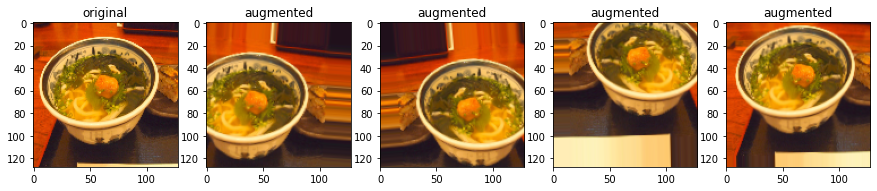

In [10]:
img = trainX[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 3))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title("original")

img = np.expand_dims(img, axis=0)
g = data_gen.flow(img, batch_size=1)

for i in range(4):
    batches = g.next()
    img_aug = batches[0]
    plt.subplot(1, 5, i+2)
    plt.imshow(img_aug)
    plt.title("augmented")

## 学習

### モデルの構築
ImageNetと呼ばれるデータセットによって学習済みの[VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16)というモデルを利用します。

その他の有名なモデルとしては次のようなものがあります。


* [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/)
* [MobileNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/)
* [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/)
* [EfficientNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/)





58892288/58889256 [==============================] - 1s 0us/step


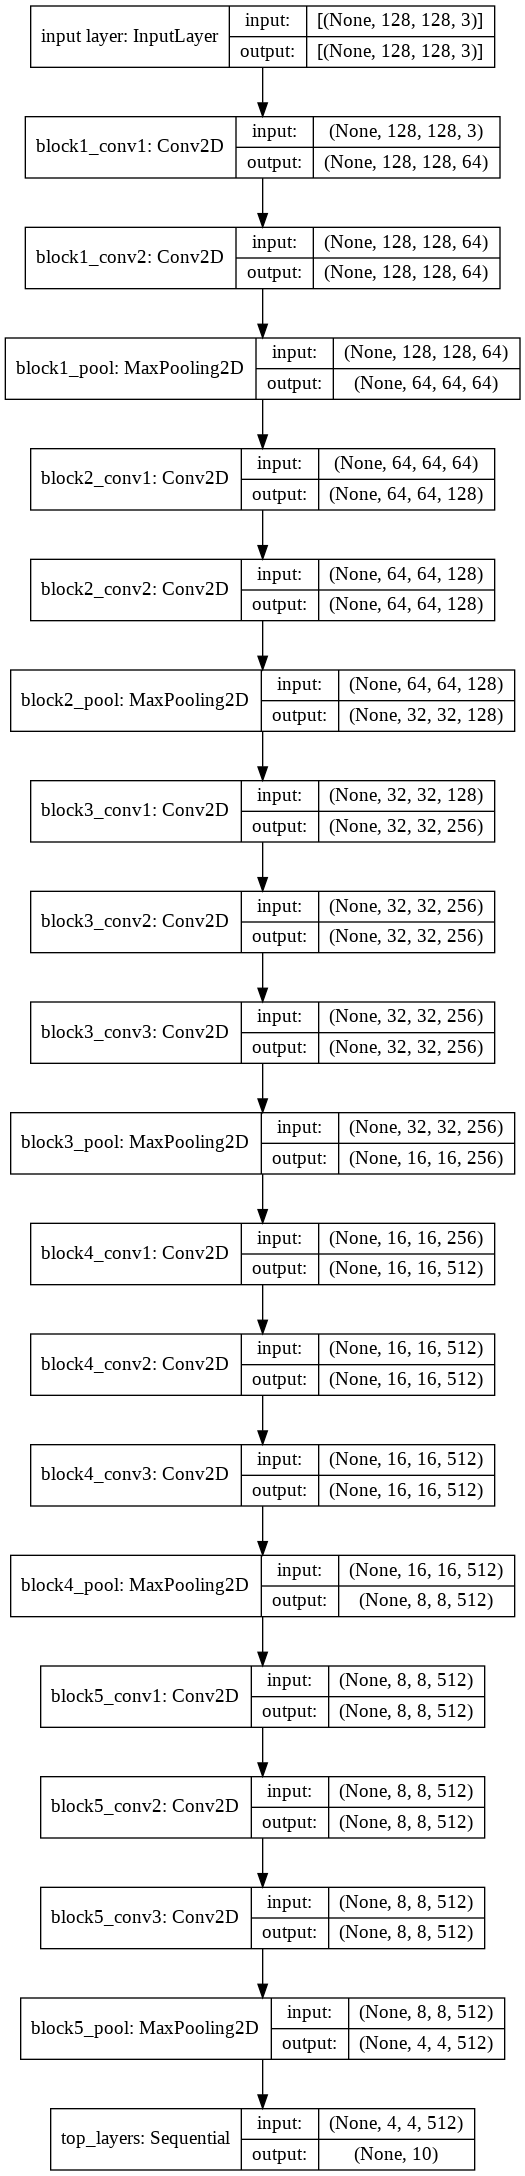

In [11]:
# VGG16
from tensorflow.keras.applications.vgg16 import VGG16

# 入力データサイズの設定
input_tensor = Input(shape=(128, 128, 3), name="input layer")

# VGG16のロード。全結合層は不要なので include_top=False
vgg16 = VGG16(input_tensor=input_tensor,
              include_top=False,
              weights='imagenet')

# vgg16のあとに連結する全結合層の作成
top_model = Sequential(name="top_layers")
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(units=128, activation='relu'))
top_model.add(Dropout(rate=0.2))
top_model.add(Dense(units=10, activation='softmax'))

# CNNの部分と全結合層を結合して新しいVGG16モデルを作成
model = Model(inputs=vgg16.input,
              outputs=top_model(vgg16.output),
              name="vgg16")

# 0番目から15番目までの層のパラメータを固定
#for layer in model.layers[:15]:
#    layer.trainable = False

# 構築したモデルを可視化して確認
plot_model(model, show_shapes=True)

どの層のパラメータが学習可能になっているか確認しましょう。

In [12]:
print("#      Layer Name        Trainable?")
print("------------------------------------")
for i, layer in enumerate(model.layers):
    print(f"{i:0>2}     {layer.name.ljust(15)}    {layer.trainable}")
print("------------------------------------")

#      Layer Name        Trainable?
------------------------------------
00     input layer        True
01     block1_conv1       True
02     block1_conv2       True
03     block1_pool        True
04     block2_conv1       True
05     block2_conv2       True
06     block2_pool        True
07     block3_conv1       True
08     block3_conv2       True
09     block3_conv3       True
10     block3_pool        True
11     block4_conv1       True
12     block4_conv2       True
13     block4_conv3       True
14     block4_pool        True
15     block5_conv1       True
16     block5_conv2       True
17     block5_conv3       True
18     block5_pool        True
19     top_layers         True
------------------------------------


学習させるパラメータの数を確認しましょう。

In [13]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input layer (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### モデルのコンパイル

モデルを学習させるためにコンパイルします。

In [14]:
model.compile(
                loss="categorical_crossentropy", 
                optimizer=Adam(1E-4),
                metrics=["accuracy"]
            )

### Callbackの設定
ReduceLROnPlateau, ModelCheckpoint, EarlyStoppingの3つのcallbackを設定します。

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              factor=0.5,
                              lr_min = 1E-7,
                              verbose=1
                             )

In [16]:
model_path = os.path.join(working_dir, "UdonAI_best_vgg16_model.h5")

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True,
                              mode="auto",
                             )

In [17]:
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              mode='auto',
                              verbose=1
                             )

### モデルの学習（トレーニング）


In [18]:
batch_size = 64
train_data_size = trainX.shape[0]
steps_per_epoch = train_data_size//batch_size

history = model.fit(
                    data_gen.flow(trainX, trainY_onehot),
                    steps_per_epoch=steps_per_epoch,
                    batch_size=batch_size,
                    epochs=100,
                    validation_data=(validX, validY_onehot),
                    shuffle=True,
                    verbose=1,
                    callbacks = [reduce_lr, modelcheckpoint, earlystopping]
                   )

Epoch 1/100
156/156 [==============================] - 72s 232ms/step - loss: 2.1522 - accuracy: 0.1990 - val_loss: 1.6954 - val_accuracy: 0.4180

Epoch 00001: val_loss improved from inf to 1.69544, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_vgg16_model.h5
Epoch 2/100
156/156 [==============================] - 26s 167ms/step - loss: 1.6628 - accuracy: 0.4147 - val_loss: 1.3912 - val_accuracy: 0.5440

Epoch 00002: val_loss improved from 1.69544 to 1.39119, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_vgg16_model.h5
Epoch 3/100
156/156 [==============================] - 26s 166ms/step - loss: 1.3476 - accuracy: 0.5242 - val_loss: 1.0219 - val_accuracy: 0.6560

Epoch 00003: val_loss improved from 1.39119 to 1.02188, saving model to /content/drive/MyDrive/DL_Lecture_202107/UdonAI_best_vgg16_model.h5
Epoch 4/100
156/156 [==============================] - 26s 167ms/step - loss: 1.1144 - accuracy: 0.6202 - val_loss: 0.9869 - val_accuracy: 0.69

### 学習経過の確認

Text(0, 0.5, 'Accuracy & Loss')

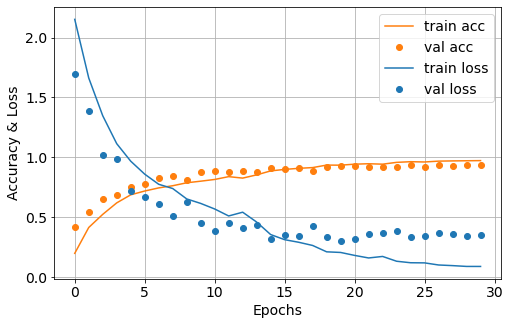

In [19]:
plt.figure(figsize=(8,5))
plt.rcParams["font.size"]=14

epoch = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

## 学習済みモデルの評価（検証用データを利用）

### 学習済みモデルの読み込み

In [20]:
model = load_model(model_path)

### すべての検証用データに対してうどん店を推論

In [21]:
predY_valid_onehot = model.predict(validX)
predY_valid = np.argmax(predY_valid_onehot, axis=1)

### 推論結果の一部を可視化
学習済みモデルを使ってvalidXのデータから推論した結果の一部を表示してみましょう。Tが正解値，Pが推論結果です。

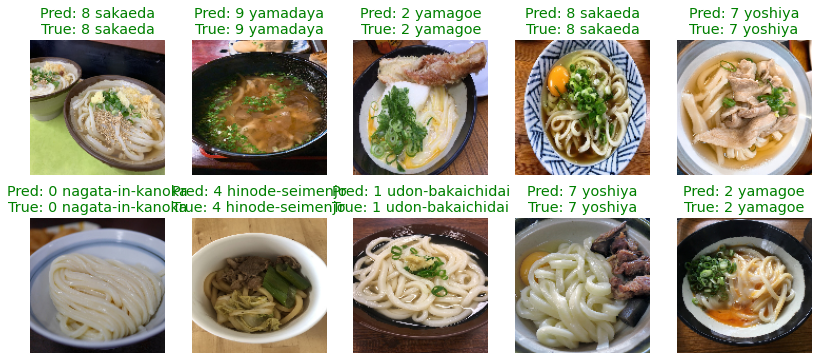

In [22]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = validX[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
    true_index = validY[i]
    pred_index = predY_valid[i]
   
    if true_index == pred_index:
        color = "green"
    else:
        color = "red"
    
    title = f"Pred: {pred_index} {udonya_list[pred_index]}\nTrue: {true_index} {udonya_list[true_index]}"
    plt.title(title, color=color)

### モデルの精度を検証
全ての検証用データに対するモデルの精度を統計的に検証します。

In [23]:
score = model.evaluate(validX, validY_onehot)
print(f"Validation Accuracy = {score[1]:.2f}")

16/16 [==============================] - 1s 42ms/step - loss: 0.3029 - accuracy: 0.9300
Validation Accuracy = 0.93


### 混同行列
モデルの精度をより詳しく検証するために混同行列を確認しましょう。

Text(0.5, 38.0, 'Prediction')

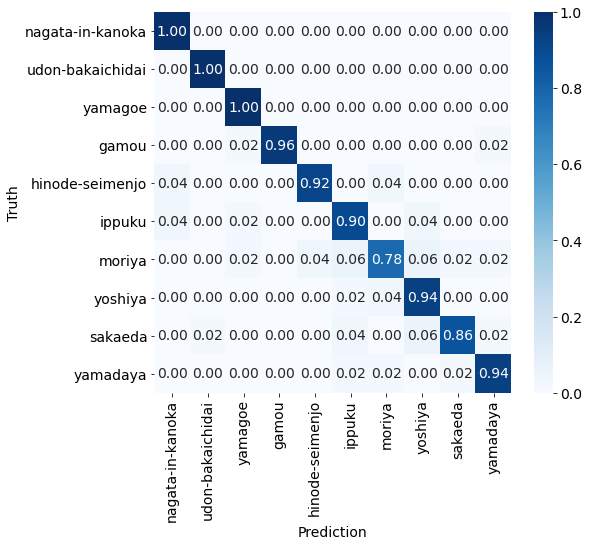

In [24]:
cmx = np.array(confusion_matrix(validY, predY_valid))    # 混同行列confusion matrixを作成

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.rcParams["font.size"]=14
plt.figure(figsize=(8,7))
sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=udonya_list, yticklabels=udonya_list)

plt.ylabel("Truth")
plt.xlabel("Prediction")

## コンペティション

### usernameの設定
```username```に自分の名前を記入してください。

**注意**
* 提出用ファイルとランキングのリストに反映されます。
* 半角英数字のみで記載してください。
* ハンドルネームでも構いません。他の人と同じにならないような名前を考えてください。
* 何回提出しても構いませんが，同じ```username```を使ってください。

In [25]:
username = "USERNAME"

### 提出ファイルの生成
以下のセルを実行して提出するファイルを生成してください。

In [26]:
# 推論結果（確率）が最大となる指標を求める
predY_test_onehot = model.predict(testX)
predY_test = np.argmax(predY_test_onehot, axis=1)

# pandasのDataFrameとして推論結果をまとめる
df = pd.DataFrame()
df["id"] = np.arange(len(predY_test))
df["label"]=predY_test

# 提出用ファイルを保存するパスを指定する。
submission_filename = f"{username}_submission.xlsx"
submission_path = os.path.join(working_dir, submission_filename) 

# 提出用ファイルを保存する
df.to_excel(submission_path, index=False)

### 推論結果のアップロード
以下のGoogleフォームから```username_submission.xlsx```をアップロードしてください。

https://forms.gle/ByhichUApgjkERgM8

### ランキングの確認
現在のランキングはここで確認できます。

https://drive.google.com/file/d/1gxUgeX4JZGarOEli8LuuF1eCrgH8ZM2b/view?usp=sharing